In [1]:
import cfgrib
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings
warnings.simplefilter("ignore")  # check those
sys.path.append("..")

from baselines.data_processor import DataProcessor
from baselines.exp_smoothing.smoothing import SmoothingPredictor

/home/kamil/Desktop/git/meteoapp-data/venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [2]:
# https://github.com/ecmwf/cfgrib/issues/164
grib_data = cfgrib.open_datasets('../data2022.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [3]:
feature_list = ['t2m', 'sp', 'tcc', 'u10', 'v10', 'tp']
t2m = surface.t2m.to_numpy() - 273.15  # -> C
sp = surface.sp.to_numpy() / 100       # -> hPa
tcc = surface.tcc.to_numpy()
u10 = surface.u10.to_numpy()
v10 = surface.v10.to_numpy()
tp = hybrid.tp.to_numpy().reshape((-1,) + hybrid.tp.shape[2:])
data = np.stack((t2m, sp, tcc, u10, v10, tp), axis=-1)

In [4]:
# s -> AUTOREG_SEQUENCE_LENGTH (input_size)
# fh -> FORECASTING_HORIZON
# (X1,X2,...,Xs) -> (Ys+1,Ys+2,...,Ys+fh)
s = 3
fh = 2

processor = DataProcessor(data)
X, y = processor.preprocess(s, fh, use_neighbours=False)
X_train, X_test, y_train, y_test = processor.train_test_split(X, y)

In [5]:
X_train, y_train = X_train[-100:], y_train[-100:]
X_test, y_test = X_test[:30], y_test[:30]

SIMPLE
smoothing_level     0.062558
initial_level      14.595579
Name: param, dtype: float64

0 / 5
t2m => RMSE:  4.01158; SE: 0.026842506518532167
sp => RMSE:  2.09654; SE: 0.4096169310028005
tcc => RMSE:  0.30373; SE: 0.00476475155158956
u10 => RMSE:  2.34127; SE: 0.03662939791974631
v10 => RMSE:  6.37206; SE: 0.043680050482055977
tp => RMSE:  0.00023; SE: 4.16941868965454e-06


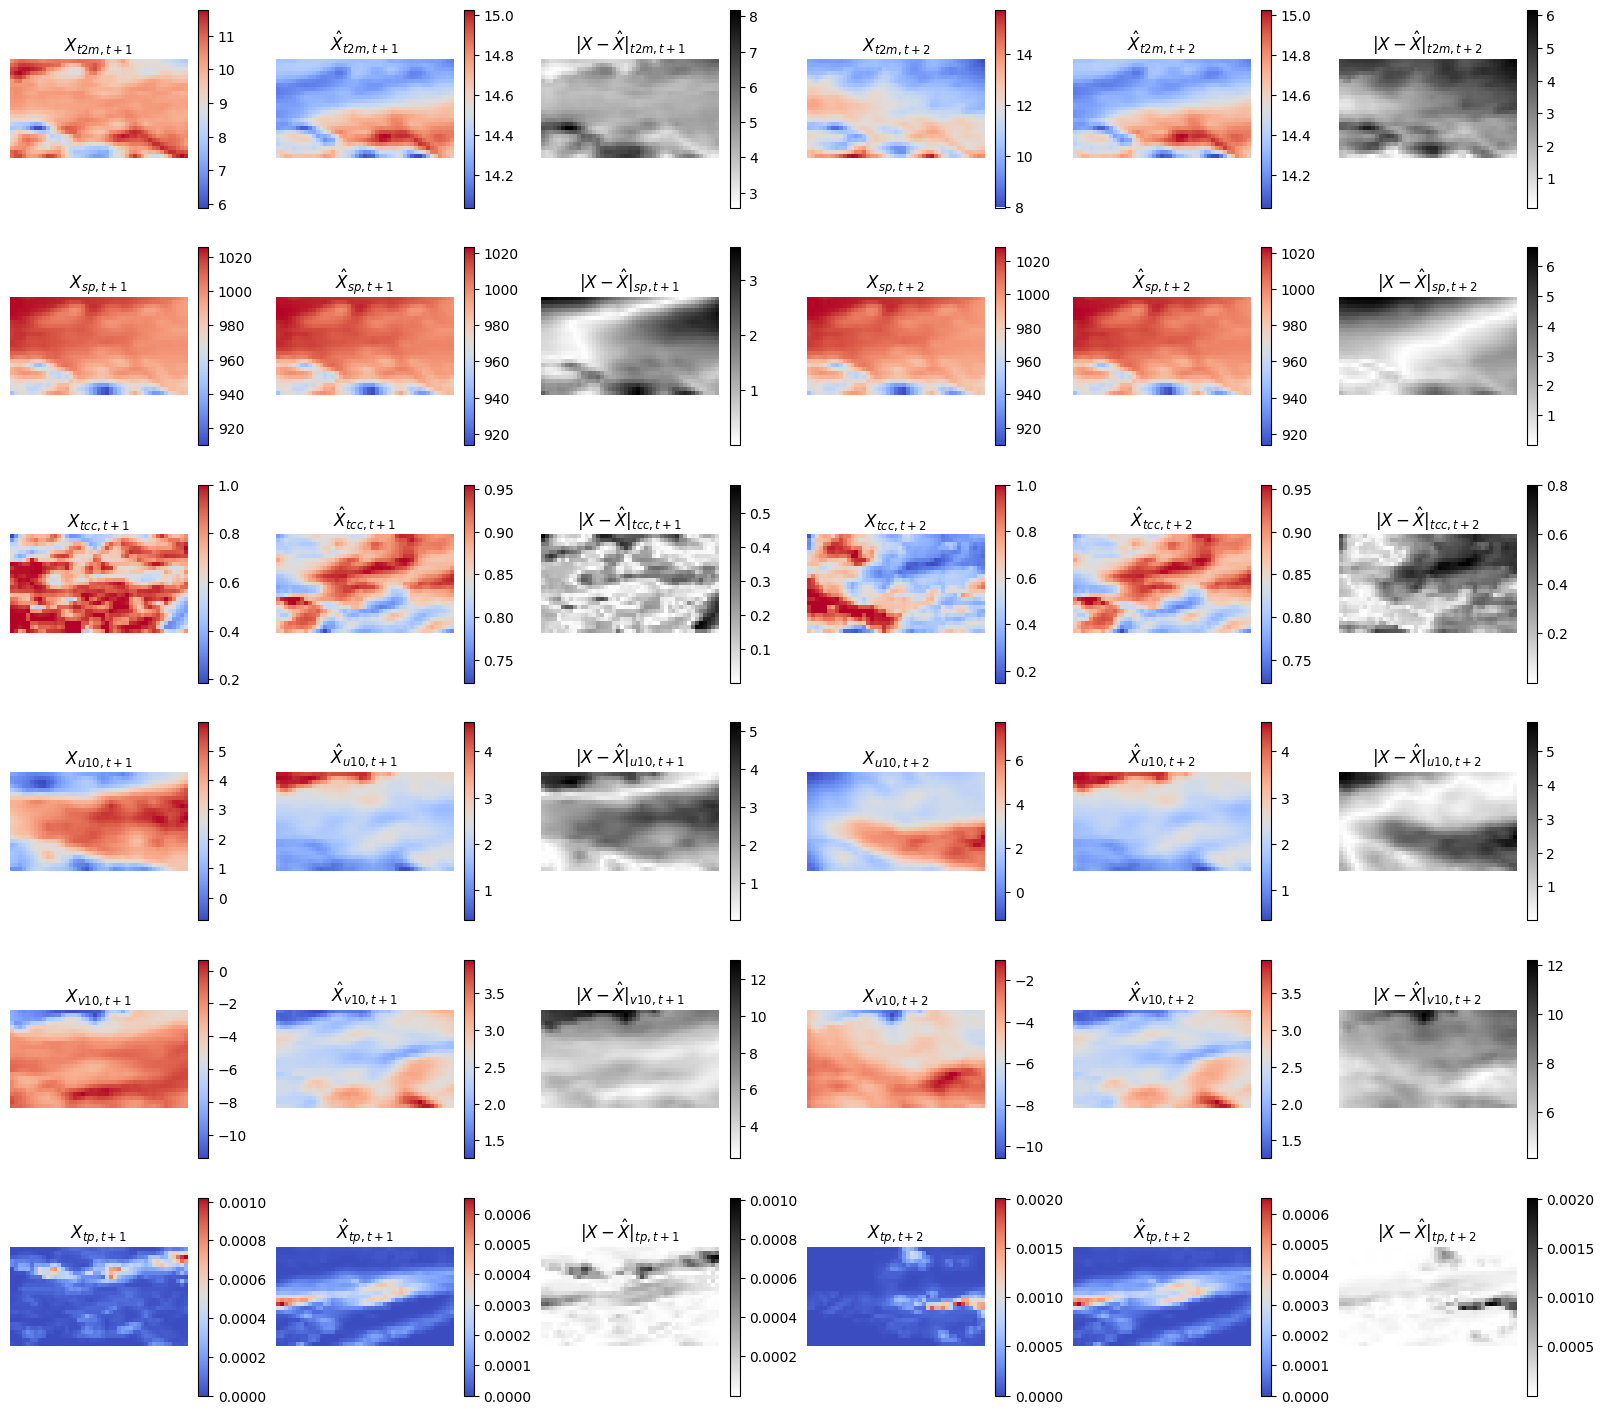

Evaluation metrics for entire test set:
t2m => RMSE: 7.966; SE: 0.03732422283837697
sp => RMSE: 2.776; SE: 0.18903580771713455
tcc => RMSE: 0.458; SE: 0.0029135340103815448
u10 => RMSE: 2.023; SE: 0.019966390519729746
v10 => RMSE: 4.698; SE: 0.022698545263720206
tp => RMSE: 0.0; SE: 1.2451386040432813e-06


 78.29815864562988 [S]


In [6]:
from time import time 
start = time()

available_types = ['simple'] # 'simple'
for smoothing in available_types:
    print(smoothing.upper())
    predictor = SmoothingPredictor(X.shape, fh, feature_list, smoothing)
    predictor.train(X_train, y_train)
    _ = predictor.predict_and_evaluate(X_test[:5], y_test[:5], max_samples=1)
    print()

stop = time()
print('\n', stop-start, '[S]')

In [ ]:
"""
HOLT:
=======================================
Evaluation metrics for entire test set:
=======================================
RMSE t2m: 316.18
RMSE sp: 923.667
RMSE tcc: 316.594
RMSE u10: 317.978
RMSE v10: 317.487
RMSE tp: 317.888

SIMPLE:
=======================================
Evaluation metrics for entire test set:
=======================================
RMSE t2m: 398.852
RMSE sp: 904.216
RMSE tcc: 399.738
RMSE u10: 401.017
RMSE v10: 400.634
RMSE tp: 401.159

ALL AROUND - TERRIBLE RESULTS

For łopatologiczne 4 for loops
HOLT:
=======================================
Evaluation metrics for entire test set:
=======================================
RMSE t2m: 3.724
RMSE sp: 9.183
RMSE tcc: 0.48
RMSE u10: 3.243
RMSE v10: 3.007
RMSE tp: 0.0

SIMPLE:
=======================================
Evaluation metrics for entire test set:
=======================================
RMSE t2m: 3.706
RMSE sp: 2.855
RMSE tcc: 0.48
RMSE u10: 3.494
RMSE v10: 2.75
RMSE tp: 0.0
"""